In [1]:
import numpy as np
import pandas as pd
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

from numba import njit

mpl.rcParams.update({'font.size':         14
                    ,'axes.edgecolor':   'black'
                    ,'axes.labelcolor':  'black'
                    ,'xtick.color':      'black'
                    ,'ytick.color':      'black'
                    ,'axes.facecolor':   'none' 
                    ,'figure.facecolor': 'none' 
                    ,'animation.html':   'jshtml'
                    })

# Ising Model of a Magnet
The Ising model comprises $N$ spins $S_i$ on a lattice (so that $i$ = 1, ... , $N$), each of which can point up, $S_i = 1$, or down, $S_i = −1$. Each neighbouring pair of aligned spins lowers the energy of the system by an amount $J > 0$. Thus, given a spin configuration ${Si}$, the total energy is
$$E({Si}) = −J \sum_{\{i, j\}} S_i S_j$$
where the sum is over all distinct nearest neighbour pairs $\{i, j\}$. According to the Boltzmann distribution, that probability of observing a given configuration $\{S_i\}$ at equilibrium is
$$P(\{S_i\}) = \exp (−E(\{S_i\})/(k_B T)) $$
where $k_B$ is Boltzmann’s constant and $T$ is the temperature.

As the physics of the system is determined by the ratio between $J$ and $k_B T$ (which enters the Boltzmann weight), we can take any two of $J$, $k_B$ and $T$ equal to unity with no loss of generality – in practice calculations normally have $J = k_B = 1$. Of course, setting J = kB = T = 1 does lose generality.

In [2]:
def make_grid(T: int, size: int) -> np.array([[]]):
    """ Creates a new grid. """
    p = np.exp(-1/T)
    return np.random.choice(a=[1, -1], size=(size, size), p=(p, 1-p))

temp:  float   = 1
size:   int    = 50
sweep:  int    = size * size
grid: [[int]]  = make_grid(temp, size)

frame_count:          int = 100

equilibration_sweeps: int = 100
measurement_sweeps:   int = 10
measurement_count:    int = 1000
n_bootstrap_samples:  int = 1000

In [3]:
@njit
def magnetisation(grid: np.array([[]])) -> int:
    """ Calculates the total magnetisation as a sum of all spins. """
    return np.sum(grid)

def energy(grid: np.array([[]])) -> int:
    """ Calculates the total energy using the right and lower neighbour pairs. """
    return (-1) * ( np.sum(grid * np.roll(grid, 1, axis=1)) + np.sum(grid * np.roll(grid, 1, axis=0)) ) 

### Glauber dynamics
One way to sample an equilibrium state of the Ising model is to use Glauber dynamics in conjunction with the Metropolis algorithm. Specifically, one chooses a site $i$ at random, and considers the effect of flipping the spin at this site. Let the resulting change in energy if the move is actually performed be $\Delta E$. Then, if $\Delta E \leq 0$, the spin flip is always flipped; otherwise it is flipped only with probability $exp(− \Delta E/k_B T)$.

In [4]:
@njit
def energy_point(grid: np.array([[]]), x: int, y: int) -> int:
    """ Calculates the energy at a grid point by considering cardinal neighbours. 
        E = -J sum(neighbours) SiSj where J=1 """
    return (-1) * grid[x][y] * (grid[(x+1)%size][y] + grid[(x-1)%size][y] + grid[x][(y+1)%size] + grid[x][(y-1)%size]) 

@njit
def step_glauber(grid: np.array([[]]), T: int) -> np.array([[]]):
    """ Calculates 1 flip attempt using Glauber dynamics at temperature T. """
    
    # generate random coordinates
    x, y = np.random.choice(a=size, size=2)
    
    # calculate energy change by flipping a spin
    E1 = energy_point(grid, x, y)
    grid[x][y] *= -1
    E2 = energy_point(grid, x, y)
    dE = E2 - E1
    
    # revert the flip if necessary
    if dE > 0 and np.exp(-dE/T) < np.random.random():
        grid[x][y] *= -1
    return grid

### Kawasaki dynamics
An alternative way to sample an equilibrium state of the Ising model is to use Kawasaki dynamics. Here, one chooses randomly two distinct sites $i$ and $j$ (these may also be nearest neighbours), and considers the effect of exchanging this pair of spins. Again, a decrease in energy means the exchange is then made; otherwise it is made with probability $\exp(− \Delta E / k_B T)$ where $\Delta E$ is the change in energy that would result from the exchange. 

In [5]:
@njit
def step_kawasaki(grid: np.array([[]]), T: int) -> np.array([[]]):
    """ Calculates 1 swap attempt using Kawasaki dynamics at temperature T. """
    # get two random point indices
    x1, y1, x2, y2 = np.random.choice(a=size, size=4)
    
    # if the spins are identical, exit
    if grid[x1][y1] == grid[x2][y2]:
        return grid
    
    # calculate energy change via flipping values
    E1 = energy_point(grid, x1, y1) + energy_point(grid, x2, y2)
    grid[x1][y1] *= -1
    grid[x2][y2] *= -1
    E2 = energy_point(grid, x1, y1) + energy_point(grid, x2, y2)
    dE = E2 - E1
    
    # revert swap if necessary
    if dE > 0 and np.exp(-dE/T) < np.random.random():
        grid[x1][y1] *= -1
        grid[x2][y2] *= -1
    return grid

## Magnetisation & Heat Capacity
The total magnetisation of a configuration ${S_i}$ is defined as $M =
\sum_i S_i$. We can use the program to estimate the average value of the total magnetisation in the equilibrium state, $\langle M \rangle$, and of the susceptibility

$$\chi = \frac{1}{Nk_bT} (\langle M^2 \rangle - \langle M \rangle ^2)$$


as a function of temperature $T$, and use these graphs to estimate the location of the critical temperature at which the system spontaneously magnetises under Glauber dynamics.

We can also look at the average of the total energy, $\langle E \rangle$, and the scaled heat capacity (or heat capacity per spin)

$$ C = \frac{1}{Nk_bT^2} (\langle E^2 \rangle - \langle E \rangle ^2) $$

and plot these quantities as a function of $T$ (including errors) to estimate the critical temperature.

### Data generation

In [6]:
def generate_glauber():
    """ Generates a Glauber dynamics Ising model dataset via Monte Carlo. """
    with open('glauber.csv', 'w', newline='') as file:
        
        writer = csv.writer(file)
        writer.writerow(['temperature', 'iteration', 'energy', 'magnetisation'])
        
        # initialise the lowest energy grid
        grid = np.full(shape=(size, size), fill_value=-1)
    
        # for each temperature
        for T in np.arange(1.0, 3.25, 0.05):
            print(f'{T:.2f}')
            
            # equilibrate the system
            for _ in range(equilibration_sweeps * sweep):
                grid = step_glauber(grid, T)
                
            # take measurements
            for i in range(measurement_count):
                for _ in range(measurement_sweeps * sweep):
                    grid = step_glauber(grid, T)
                writer.writerow([f'{T:.2f}', i, energy(grid), magnetisation(grid)])
            file.flush()

def generate_kawasaki():
    """ Generates a Kawasaki dynamics Ising model dataset via Monte Carlo. """
    with open('kawasaki.csv', 'w', newline='') as file:
        
        writer = csv.writer(file)
        writer.writerow(['temperature', 'iteration', 'energy'])
        
        # initialise the lowest energy grid
        grid = np.ones(shape=(size, size))
        grid[:size//2, :] *= -1

        # for each temperature
        for T in np.arange(1.0, 3.25, 0.05):
            print(f'{T:.2f}')

            # equilibrate the system
            for _ in range(equilibration_sweeps * sweep):
                grid = step_kawasaki(grid, T)

            # take measurements
            for i in range(measurement_count):
                for _ in range(measurement_sweeps * sweep):
                    grid = step_kawasaki(grid, T)
                writer.writerow([f'{T:.2f}', i, energy(grid)])
            file.flush()

In [ ]:
# generate_glauber()
# generate_kawasaki()

In [8]:
# load generated data
df_g = pd.read_csv('glauber.csv')
df_k = pd.read_csv('kawasaki.csv')

# normalise magnetisation as absolute value
df_g['magnetisation_abs'] = df_g['magnetisation'].abs()

[Text(0.5, 0, '$T$'),
 Text(0, 0.5, '$\\langle |M| \\rangle \\pm \\sigma_M$'),
 Text(0.5, 1.0, 'Glauber magnetisation (1000 runs per $T$)')]

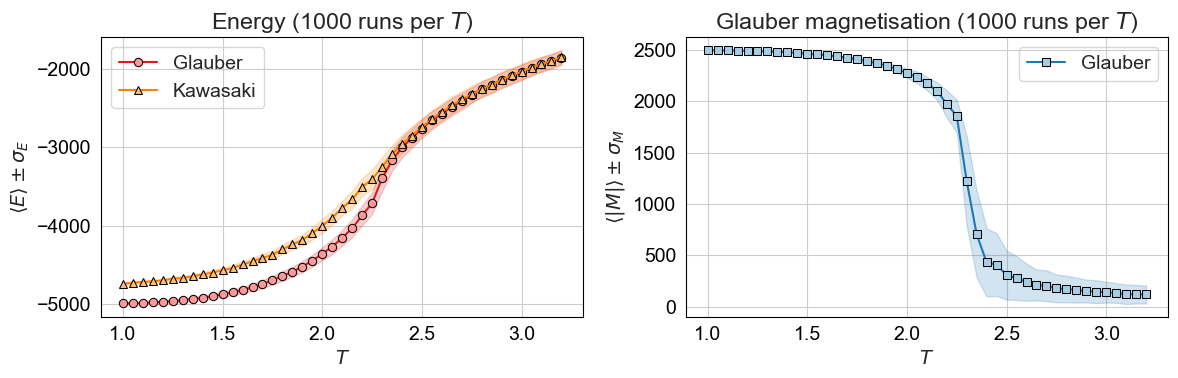

In [9]:
# plot energy and magnetisation
fig, (axl, axr) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
colors = sns.color_palette('Paired')
r_full, r_light = colors[5], colors[4]
b_full, b_light = colors[1], colors[0]
o_full, o_light = colors[7], colors[6]

# energy plot
sns.lineplot(data=df_g, ax=axl,
             x='temperature', y='energy', label='Glauber', color=r_full, 
             marker='o', markersize=6, markeredgecolor='black', markerfacecolor=r_light,
             estimator='mean', errorbar='sd')
sns.lineplot(data=df_k, ax=axl,
             x='temperature', y='energy', label='Kawasaki', color=o_full,
             marker='^', markersize=6, markeredgecolor='black', markerfacecolor=o_light,
             estimator='mean', errorbar='sd'
             ).set(xlabel='$T$', ylabel='$\\langle E \\rangle \\pm \\sigma_E$',
                   title='Energy (1000 runs per $T$)')

# magnetisation plot
sns.lineplot(data=df_g, ax=axr,
             x='temperature', y='magnetisation_abs', label='Glauber', color=b_full,
             marker='s', markersize=6, markeredgecolor='black', markerfacecolor=b_light,
             estimator='mean', errorbar='sd'
             ).set(xlabel='$T$', ylabel='$\\langle |M| \\rangle \\pm \\sigma_M$', 
                   title='Glauber magnetisation (1000 runs per $T$)')

In [10]:
# calculate heat capacity & magnetic susceptibility
# using the formulas C = (<E^2> - <E>^2)/(NT^2) ; X = (<M^2> - <M>^2)/(NT)
df_g2 = df_g.groupby('temperature').var().reset_index()
df_g2['heat_capacity']  = df_g2['energy'] / (df_g2['temperature'].pow(2) * sweep)
df_g2['susceptibility'] = df_g2['magnetisation'] / (df_g2['temperature'] * sweep)

df_k2 = df_k.groupby('temperature').var().reset_index()
df_k2['heat_capacity']  = df_k2['energy'] / (df_k2['temperature'].pow(2) * sweep)

In [11]:
# calculate the error as the un-normalised standard deviation of bootstrapped heat capacities
# glauber
e = df_g[['temperature', 'energy']].to_numpy()
df_g2['heat_capacity_err'] = [                                                # get error of C_v as st. dev.
    np.std(np.var(np.random.choice(es, size=(n_bootstrap_samples, measurement_count)),
                  axis=1) / (sweep * T ** 2))                                 # from bootstrapped C_i samples
    for T, es in zip(df_g2['temperature'],                                    # for each temperature
           np.split(e[:,1], np.unique(e[:, 0], return_index=True)[1][1:])) ]  # and all energies at that temperature

# kawasaki
e2 = df_k[['temperature', 'energy']].to_numpy()
df_k2['heat_capacity_err'] = [                                                # get error of C_v as st. dev.
    np.std(np.var(np.random.choice(es, size=(n_bootstrap_samples, measurement_count)),
                  axis=1) / (sweep * T ** 2))                                 # from bootstrapped C_i samples
    for T, es in zip(df_k2['temperature'],                                    # for each temperature
           np.split(e[:,1], np.unique(e2[:, 0], return_index=True)[1][1:])) ] # and all energies at that temperature

# same procedure for glauber susceptibility
m = df_g[['temperature', 'magnetisation']].to_numpy()
df_g2['susceptibility_err'] = [                                               # get error of X as st. def.
    np.std(np.var(np.random.choice(ms, size=(n_bootstrap_samples, measurement_count)),
                  axis=1) / (sweep * T))                                      # from bootstrapped X_i samples
    for T, ms in zip(df_g2['temperature'],                                    # for each temperature
           np.split(m[:,1], np.unique(m[:, 0], return_index=True)[1][1:])) ]  # and all magnetisations at that temp

[Text(0.5, 0, '$T$'),
 Text(0, 0.5, '$\\chi \\pm \\sigma_{b(1000)}$'),
 Text(0.5, 1.0, 'Susceptibility'),
 (-2.0, 300.0)]

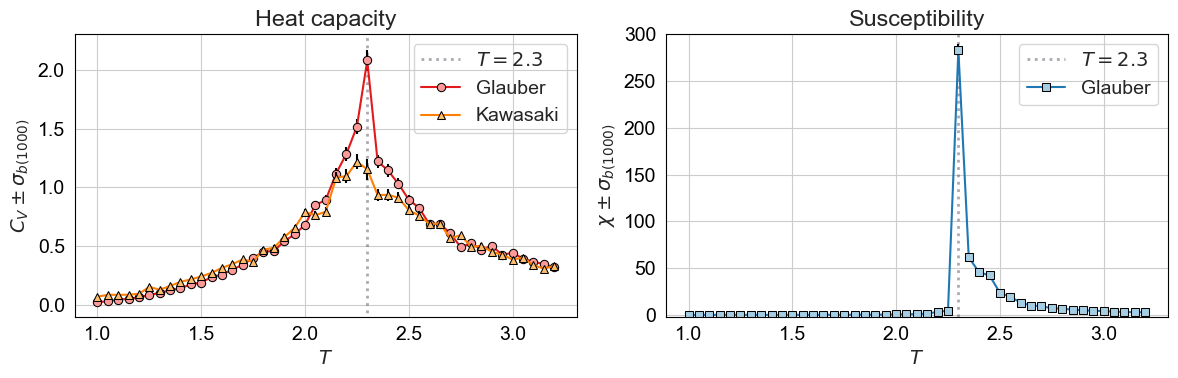

In [12]:
# plot heat capacity and susceptibility
fig, (axl, axr) = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)

# create a vertical line at highest point
axl.vlines(x=2.3, ymin=-10, ymax=50, colors='#5f5166', alpha=0.5, ls=':', lw=2, label='$T=2.3$')
axr.vlines(x=2.3, ymin=-10, ymax=300, colors='#5f5166', alpha=0.5, ls=':', lw=2, label='$T=2.3$')

# heat capacity plot
axl.errorbar(df_g2['temperature'], df_g2['heat_capacity'], yerr=df_g2['heat_capacity_err'],
             color='black', linestyle='')
sns.lineplot(data=df_g2, ax=axl,
             x='temperature', y='heat_capacity', label='Glauber', color=r_full,
             marker='o', markersize=6, markeredgecolor='black', markerfacecolor=r_light)
axl.errorbar(df_k2['temperature'], df_k2['heat_capacity'], yerr=df_k2['heat_capacity_err'],
             color='black', linestyle='')
sns.lineplot(data=df_k2, ax=axl,
             x='temperature', y='heat_capacity', label='Kawasaki', color=o_full,
             marker='^', markersize=6, markeredgecolor='black', markerfacecolor=o_light,
             ).set(xlabel='$T$', ylabel='$C_V \\pm \\sigma_{b(1000)}$',
                   title='Heat capacity', ylim=(-0.1, 2.3))

# magnetic susceptibility plot
axr.errorbar(df_g2['temperature'], df_g2['susceptibility'], yerr=df_g2['susceptibility_err'],
             color='black', linestyle='')
sns.lineplot(data=df_g2, ax=axr, 
             x='temperature', y='susceptibility', label='Glauber', color=colors[1],
             marker='s', markersize=6, markeredgecolor='black', markerfacecolor=colors[0],
             ).set(xlabel='$T$', ylabel='$\\chi \\pm \\sigma_{b(1000)}$',
                   title='Susceptibility', ylim=(-2, 300))

## Animated plots

In [ ]:
%matplotlib inline

# create the plots
fig, axes = plt.subplot_mosaic('AB;AC', figsize=(10, 6), gridspec_kw={'width_ratios': [3, 2]}, tight_layout=True)
ax  = axes['A']
axt = axes['B']
axb = axes['C']

# create the data structures
temp = 1.2
grid = make_grid(temp, size)
es, ms = [], []

# for each animation frame
def animate(i):
    global grid, temp

    # iterate sweep times
    for j in range(sweep):
        grid = step_glauber(grid, temp)

    # create the system plot
    sns.heatmap(grid, ax=ax, cbar=False)
    ax.set(title=f'Glauber Dynamics ($T$={temp}; t={i})', xticklabels=[], yticklabels=[])

    # calculate energy and magnetisation
    es.append(e := energy(grid))
    ms.append(m := magnetisation(grid))

    # create the energy and magnetisation plots
    sns.lineplot(x=range(len(es)), y=es, ax=axt, color=r_full)
    axt.set(title=f'Energy $E({i})={e}$', xlim=(0, frame_count), ylim=(-5000, 0), xticklabels=[])
    sns.lineplot(x=range(len(es)), y=ms, ax=axb, color=b_full)
    axb.set(title=f'Magnetisation $M({i})={m}$', xlim=(0, frame_count), ylim=(-2500, 2500), xticklabels=[])

a = FuncAnimation(fig, animate, frames=frame_count)
plt.close()

a